<a href="https://colab.research.google.com/github/tchotaneu/Utilisation_CLIP_OpenAI/blob/main/tuto_1(clip).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**une utlilisation du modele CLIP de OPENAI**



# Preparation de l'environnement de travail 

Assurons nous que nous exécutons sur  GPU , sinon, sélectionnez "GPU" comme accélérateur matériel dans Runtime . Changez le type de runtime dans le menu. Les prochaines cellules installeront le paquet `clip` et ses dépendances, et vérifieront si PyTorch 1.7.1 ou plus est installé.

In [1]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-jb6ddy3f
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-jb6ddy3f
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369409 sha256=d0e123b7a33009a0e0c603f49071e8ad207ffccab19fb84fba616a8ac48b334f
  Stored in directory: /tmp/pip-ephem-wheel-cache-rb2n0g7p/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


In [2]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)


Torch version: 1.12.1+cu113


**Charger le modèle**
 cette fonction `clip.available_models()` donnera la liste des noms des modèles CLIP disponibles.

In [3]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [5]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("nombre de parametres du models :", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("taille en entrée:", input_resolution)
print("Longueur du contexte:", context_length)
print("Taille des mots:", vocab_size)

nombre de parametres du models : 151,277,313
taille en entrée: 224
Longueur du contexte: 77
Taille des mots: 49408


# Prétraitement des images

Nous redimensionnons les images d'entrée et les recadrons au centre pour se conformer à la résolution d'image attendue par le modèle. Avant de faire cela, nous allons normaliser l'intensité des pixels en utilisant la moyenne et l'écart type de l'ensemble de données.

La deuxième valeur de retour de clip.load() contient une transformation torchvision qui effectue ce prétraitement.



In [6]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7fb23bb8b7a0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Prétraitement du texte

Nous utilisons un tokenizer insensible à la casse, qui peut être appelé à l'aide de `clip.tokenize()`. Par défaut, les sorties sont remplies pour devenir longues de 77 jetons, ce que les modèles CLIP attendent.

In [7]:
clip.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

# Configuration des images et des textes d'entrée

Nous allons alimenter 8 exemples d'images et leurs descriptions textuelles avec le modèle, et comparer la similarité entre les caractéristiques correspondantes.

Le tokenizer est insensible à la casse, et nous pouvons librement donner toutes les descriptions textuelles appropriées.

In [9]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# les images à utiliser dans skimage et leurs descriptions textuelles
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse", 
    "coffee": "a cup of coffee on a saucer"
}

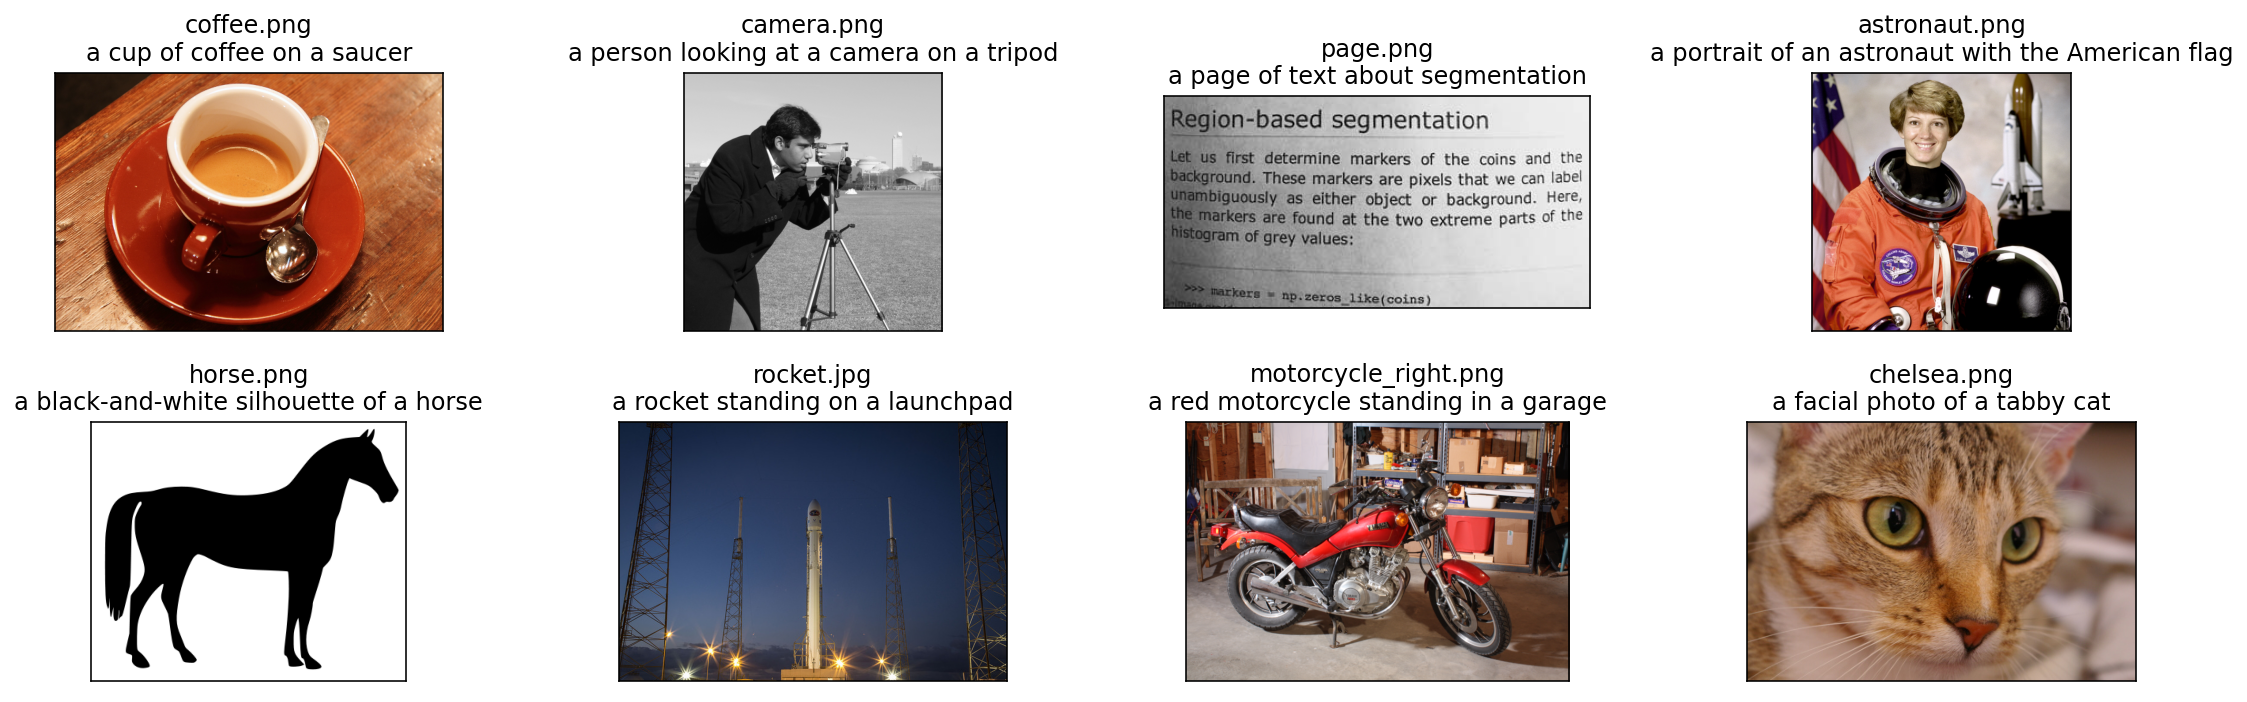

In [10]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")
  
    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()



## construisions des features 

Nous normalisons les images, nous tokenisons chaque entrée de texte, et nous exécutons avant de passé dans le modèle pour obtenir les caractéristiques de l'image et du texte.

In [11]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

In [12]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

## Calcul de la metrique similarité du cosinus

Nous normalisons les caractéristiques et calculons le produit scalaire de chaque paire.

# Nouvelle section

In [13]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, "Similitude cosinus entre le texte et l'images")

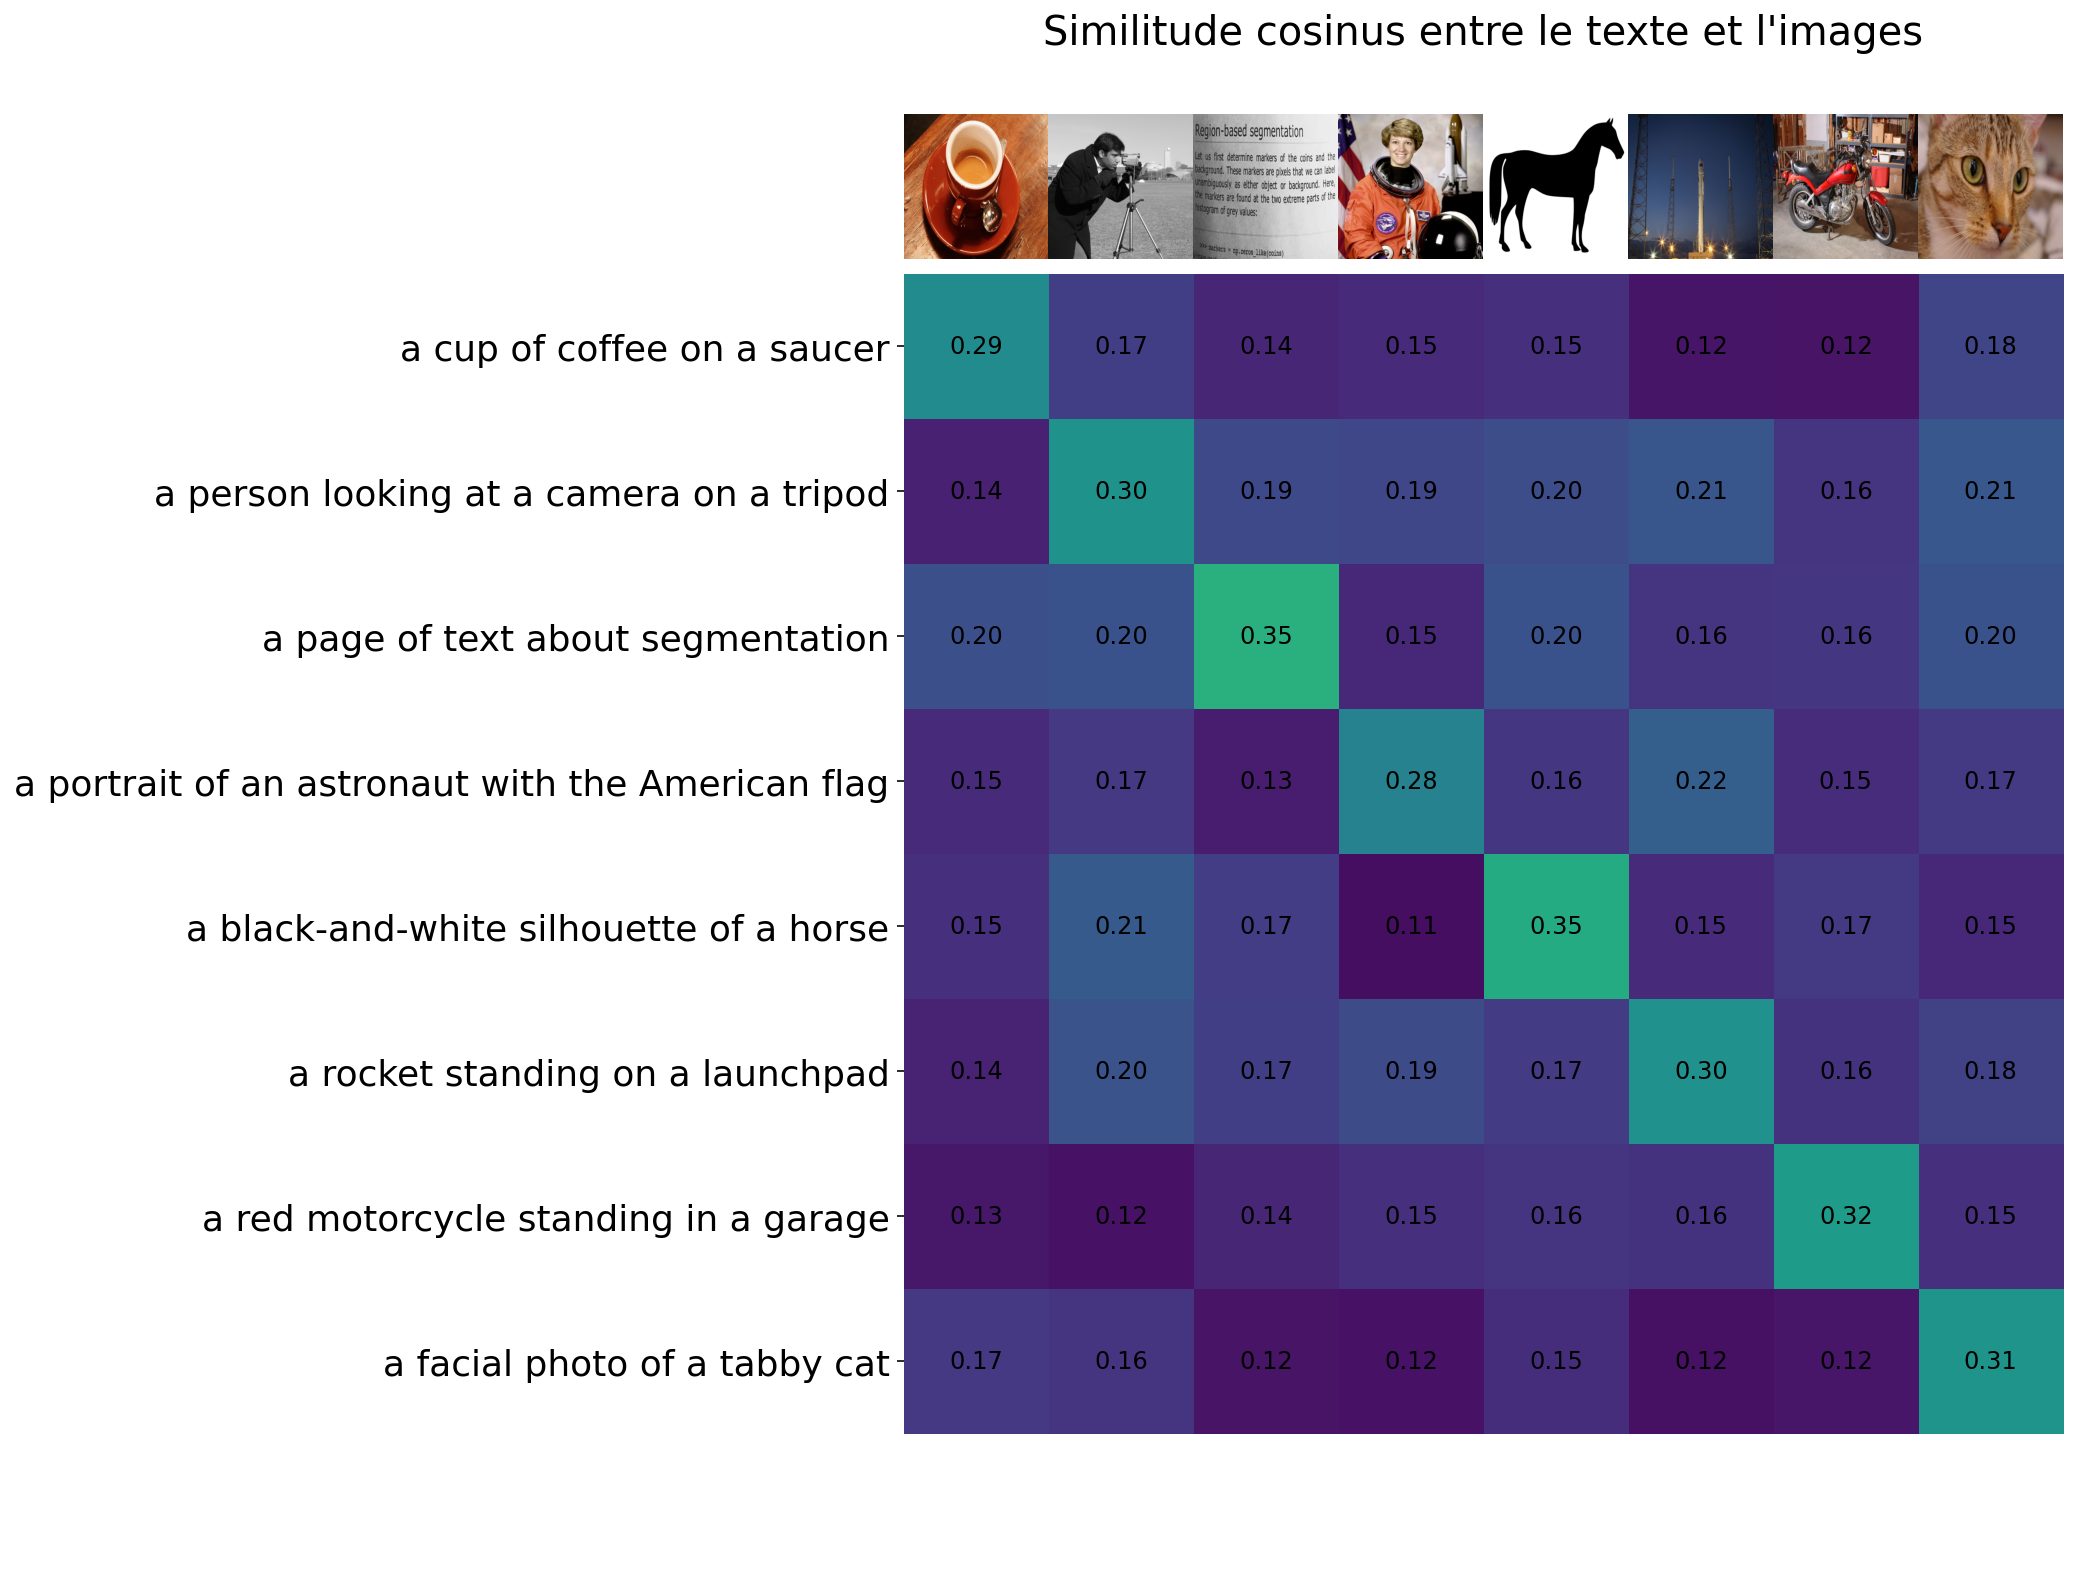

In [14]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.5)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

In [ ]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

Files already downloaded and verified


In [ ]:
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions).cuda()

In [ ]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

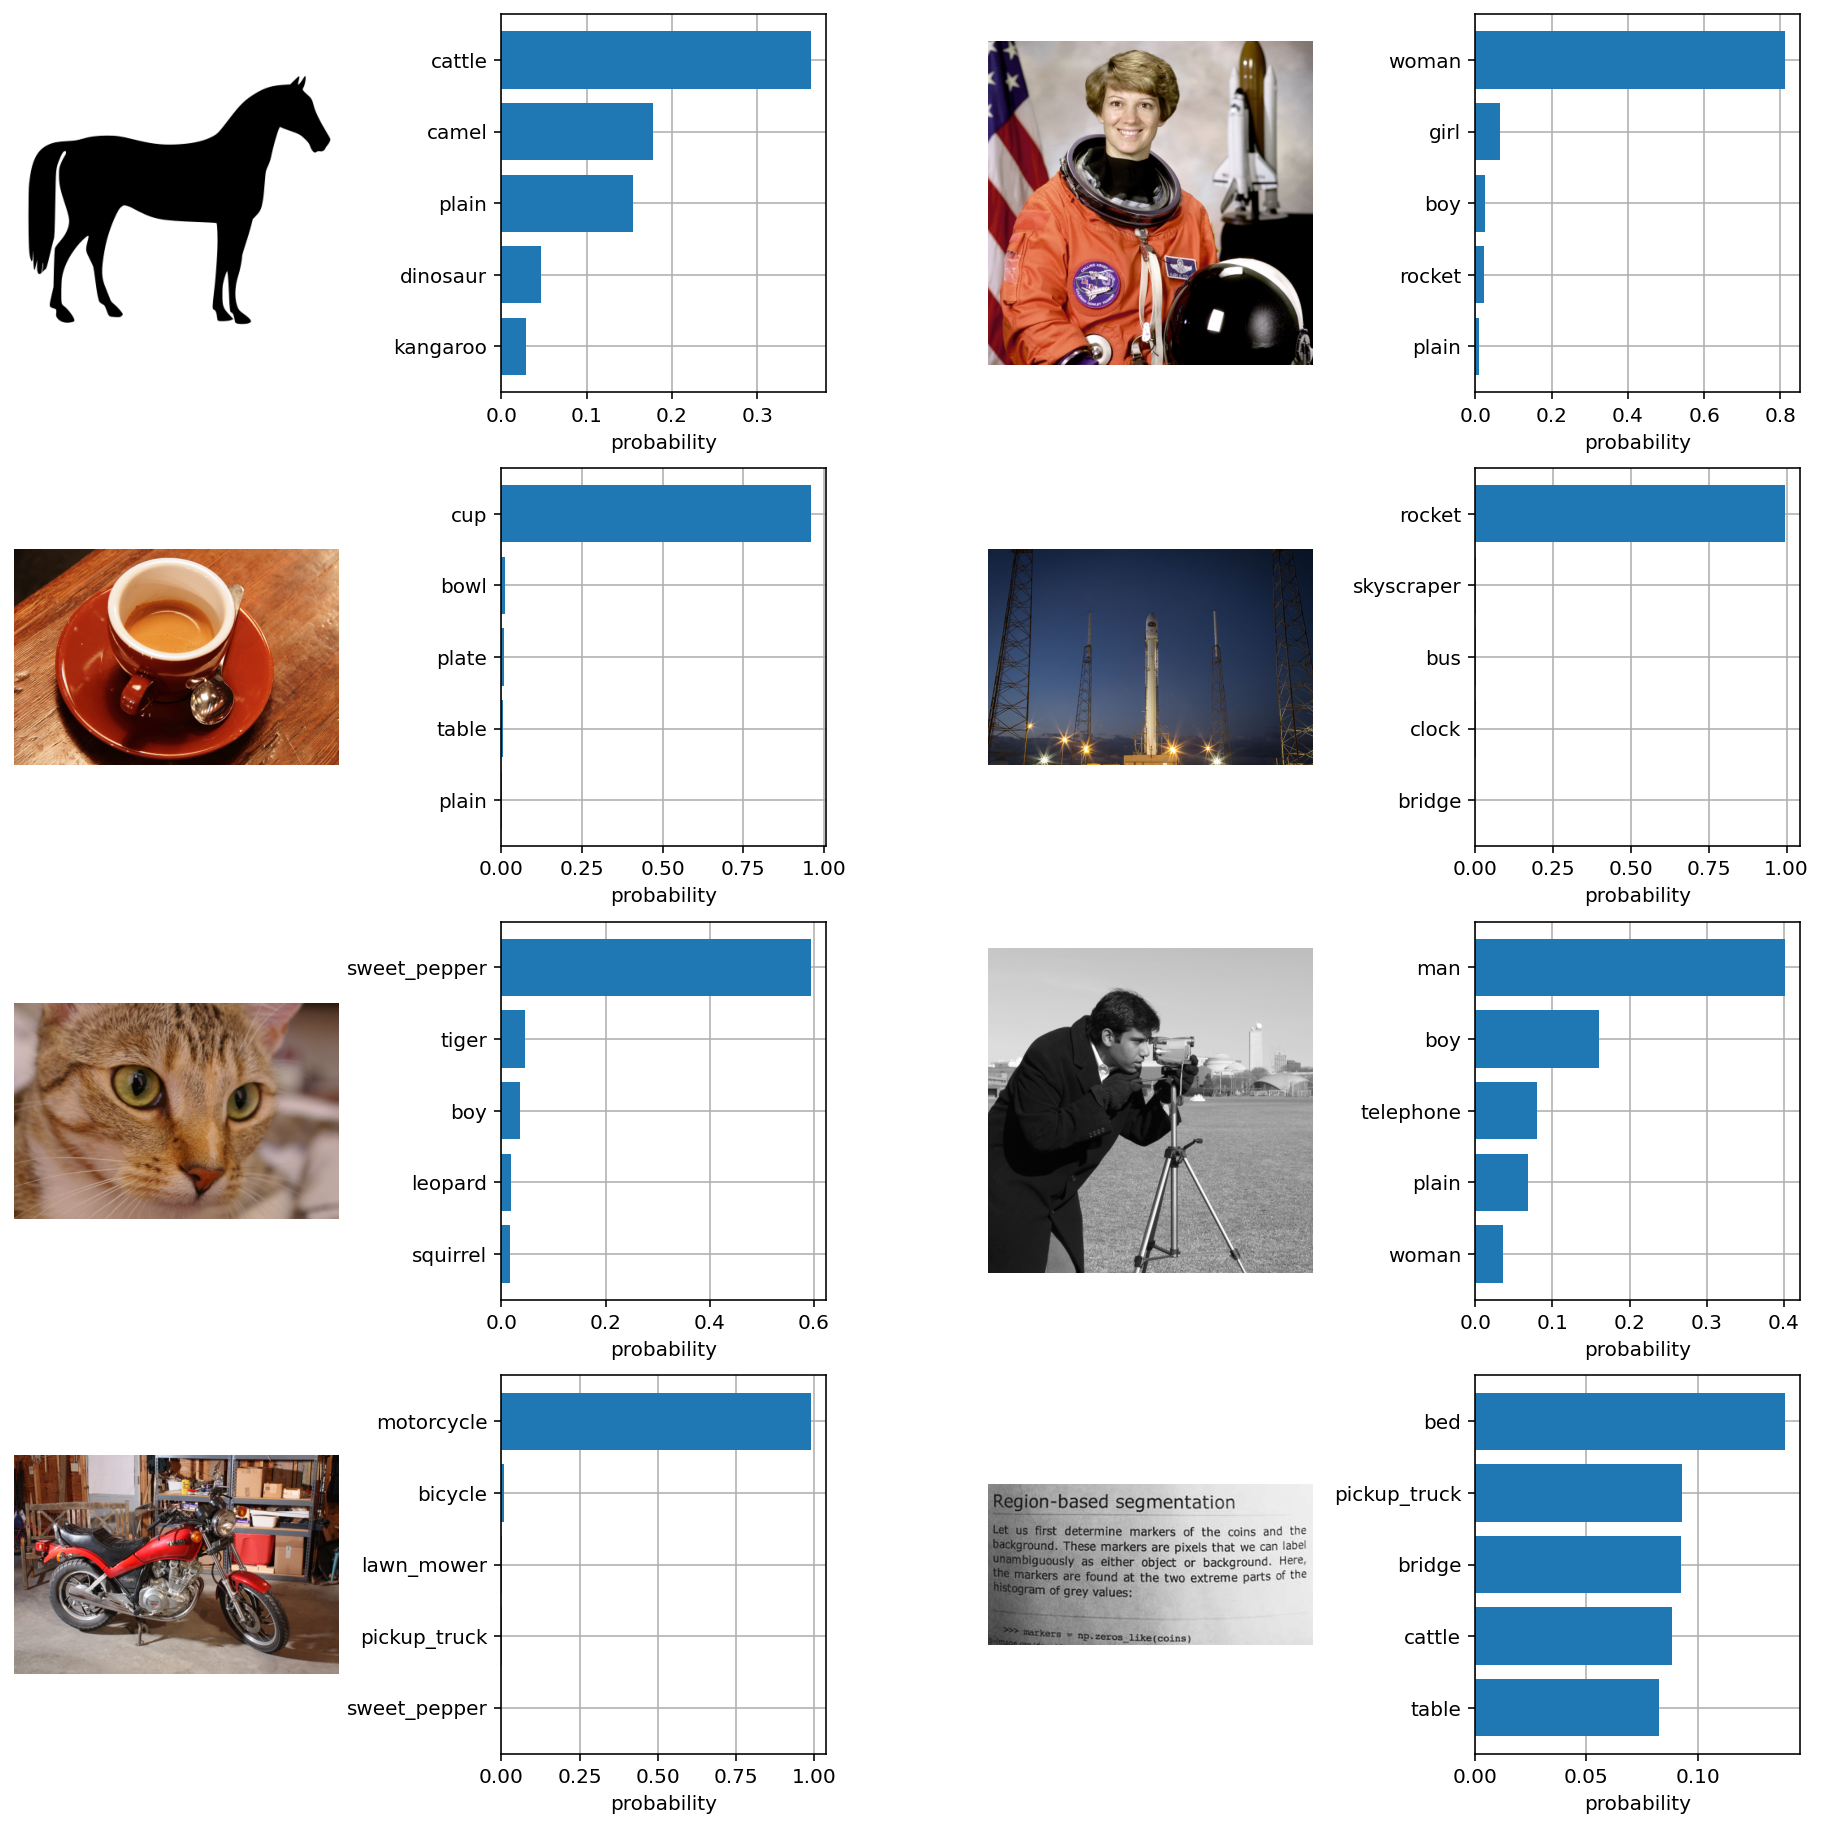

In [ ]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()